<a href="https://colab.research.google.com/github/TokyoYoshida/GoogleColab/blob/master/playground_dqn_keiba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# 必要ならば以下のようにディレクトリ移動する
 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/'My Drive'/'★個人専用ファイル'/'開発用・個人サービス開発'/'GoogleColab'/

/content/drive/My Drive/★個人専用ファイル/開発用・個人サービス開発/GoogleColab


In [3]:
%ls data/keiba


darby.csv
keiba_dat_res_20200528_2355.pkl
keiba_dat_res_20200528.pkl
keiba_dat_res_20200529_2306_20200531backup.pkl
keiba_dat_res_20200529_2306.pkl
keiba_dat_res_20200531_1207.pkl
keiba_dat_res_20200531_1707.pkl
keiba_predict_20200604_1617.pkl
result_20200528_2020年時点最新競馬データ.csv
調教師一覧.csv
調教師一覧.gsheet
馬一覧.csv
馬一覧.gsheet
騎手一覧.csv
騎手一覧.gsheet


In [0]:
import pandas as pd

In [0]:
import numpy as np

In [0]:
# 競馬データの作成

In [0]:
ldat = pd.read_pickle("./data/keiba/keiba_predict_20200604_1617.pkl")

In [0]:
# ３位以内に入ったら、複勝オッズとして1.1倍をつけておく
ldat.loc[(ldat["high_rank"]==1) & (ldat["return"] == 0), "return"] = 1.1

In [0]:
# ディープラーニングが勝ち予想した馬に限定する
ldat = ldat.query("winner_predict_win > 0")

In [0]:
sdat = ldat.sample(frac=1).reset_index(drop=True)

In [0]:
# x = sdat[['frame_num', 'horse_num', 'name', 'sex', 'age', 'amount',
#        'jockey', 'odds', 'popularity', 'weight',
#        'diff_weight', 'trainer', 'race_num', 'grade', 'ground', 'direction',
#         'distance', 'weather', 'condition', 'start_time_float', 'year',
#        'month', 'day', 'prev_rank', 'prev_frame_num', 'prev_horse_num',
#        'prev_name', 'prev_sex', 'prev_age', 'prev_amount', 'prev_jockey',
#        'prev_time_float', 'prev_diff_arrival', 'prev_odds', 'prev_popularity',
#        'prev_weight', 'prev_diff_weight', 'prev_trainer', 'prev_race_num',
#        'prev_grade', 'prev_ground', 'prev_direction',
#        'prev_distance', 'prev_weather', 'prev_condition', 'prev_start_time_float',
#        'prev_year', 'prev_month', 'prev_day']].dropna(0)

In [0]:
# x = sdat[['frame_num', 'horse_num', 'sex', 'age', 'amount',
#        'odds', 'popularity', 'weight',
#        'diff_weight', 'trainer', 'grade', 'ground', 'direction',
#         'distance', 'weather', 'condition', 'start_time_float', 'prev_rank', 'prev_frame_num', 'prev_horse_num',
#        'prev_sex', 'prev_age', 'prev_amount', 'prev_jockey',
#        'prev_time_float', 'prev_diff_arrival', 'prev_odds', 'prev_popularity',
#        'prev_weight', 'prev_diff_weight', 'prev_trainer',
#        'prev_grade', 'prev_ground', 'prev_direction',
#        'prev_distance', 'prev_weather', 'prev_condition', 'prev_start_time_float'
#        ]].dropna(0)

In [0]:
x = sdat[["odds","winner_predict_win"]].dropna(0)

In [0]:
# x = sdat[["odds"]].dropna(0)

In [0]:
y = sdat[["return"]].dropna(0)

In [0]:
# 競馬データの作成 終わり

In [0]:
# 学習、テストデータの作成

In [0]:
trainlen = int(len(x)/2)

In [0]:
trainx = x.head(trainlen)
trainy = y.head(trainlen)

In [0]:
testx = x.tail(len(x)-trainlen)
testy = y.tail(len(x)-trainlen)

In [0]:
# 学習、テストデータの作成　終わり

In [0]:
#!pip uninstall -y keras

In [0]:
#!pip uninstall -y tensorflow

In [184]:
!pip install tensorflow==1.14

In [0]:
#!pip install tensorflow

In [0]:
!pip install -q keras==2.0.8

In [0]:
import keras

In [0]:
#pip uninstall -q keras-rl

In [0]:
!pip install -q keras-rl

In [0]:
from pprint import pprint

In [191]:
trainx.min()

odds                  1.0
winner_predict_win    0.0
dtype: float64

In [192]:
!pip list

Package                  Version        
------------------------ ---------------
-ensorflow               2.2.0          
absl-py                  0.9.0          
alabaster                0.7.12         
albumentations           0.1.12         
altair                   4.1.0          
asgiref                  3.2.7          
astor                    0.8.1          
astropy                  4.0.1.post1    
astunparse               1.6.3          
atari-py                 0.2.6          
atomicwrites             1.4.0          
attrs                    19.3.0         
audioread                2.1.8          
autograd                 1.3            
Babel                    2.8.0          
backcall                 0.1.0          
beautifulsoup4           4.6.3          
bleach                   3.1.5          
blis                     0.4.1          
bokeh                    1.4.0          
boto                     2.49.0         
boto3                    1.13.19        
botocore        

In [193]:
np.array(trainx.iloc[1])

array([16.3,  0. ])

In [194]:
float(trainy.iloc[0])

0.0

In [0]:
import numpy as np

import gym
from gym import spaces
from gym.utils import seeding


class HotterColder(gym.Env):
    """Hotter Colder
    The goal of hotter colder is to guess closer to a randomly selected number
    After each step the agent receives an observation of:
    0 - No guess yet submitted (only after reset)
    1 - Guess is lower than the target
    2 - Guess is equal to the target
    3 - Guess is higher than the target
    The rewards is calculated as:
    (min(action, self.number) + self.range) / (max(action, self.number) + self.range)
    Ideally an agent will be able to recognise the 'scent' of a higher reward and
    increase the rate in which is guesses in that direction until the reward reaches
    its maximum
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y

        self.range = 10  # +/- value the randomly select number can be between
        self.bounds = 20  # Action space bounds

        self.number = 0
        self.guess_count = 0
        self.guess_max = 200
        self.race_num = 0

        self.action_space = gym.spaces.Discrete(11)
        min = np.array(self.x.min())
        low = np.concatenate([min])
        max = np.array(self.x.max())        
        high = np.concatenate([max])
        self.observation_space = gym.spaces.Box(low=low, high=high) 
        
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        self.done =  self._is_done(action)

        reward = 0
        plus = 0
        if self.done == False:
          if action > 0:
            plus = (-1 * action + float(self.y.iloc[self.race_num]*action))
            reward = plus
            self.amount += plus
        else:
            reward = self.amount

#          print("")

#         self.amount += reward

        self.guess_count += 1
        self.race_num += 1

        if self.race_num >= len(self.x):
          self.race_num = 0

#        print(action, end="")
#        pprint((self.x.iloc[self.race_num], reward, self.done, {"guesses": self.guess_count}))
        return np.array(self.x.iloc[self.race_num]), reward, self.done, {"guesses": self.guess_count}

    def reset(self):
        self.done = False
        self.amount = 0
        self.guess_count = 0
        
#        pprint(np.concatenate([[self.amount],np.array(self.x.iloc[self.race_num])]))
        return np.array(self.x.iloc[self.race_num])
      
    def _is_done(self, action):
        if self.guess_count >= self.guess_max:
#           print("Over")
          return True
        return False

In [196]:
env = HotterColder(trainx, trainy)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
#x =  spaces.Box(low=np.array([-200]), high=np.array([200]),                                       dtype=np.float32)

In [0]:
nb_actions = env.action_space.n


In [199]:
nb_actions

11

In [0]:
# env.action_space.contains(np.array([-2000]))


In [0]:
# import gym

# # GymのPendulum環境を作成
# env = gym.make("Pendulum-v0")

# # 取りうる”打ち手”のアクション数と値の定義
# nb_actions = 2
# ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [0]:
from rl.core import Processor


class PendulumProcessor(Processor):

    # Duel-DQNの出力と、Gym環境の入力の違いを吸収
    def process_action(self, action):
        return action

    # Gym環境の報酬の出力と、Duel-DQNの報酬の入力との違いを吸収
    def process_reward(self, reward):
      return reward
#         if reward > -0.2:
#             return 1
#         elif reward > -1.0:
#             return 0
#         else:
#             return 0
    def process_observation(self, observation):
      return observation

processor = PendulumProcessor()

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten


model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dense(nb_actions, activation="linear"))

In [204]:
(1,) + env.observation_space.shape

(1, 2)

In [205]:
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory


# Duel-DQNアルゴリズム関連の幾つかの設定
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()

# Duel-DQNのAgentクラスオブジェクトの準備 （上記processorやmodelを元に）
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               enable_dueling_network=True, dueling_type="avg", target_model_update=1e-2, policy=policy,processor=processor)
dqn.compile(Adam(lr=1e-3), metrics=["mae"])
print(dqn.model.summary())




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3_input (InputLayer) (None, 1, 2)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                48        
_________________________________________________________________
activation_5 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_6 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 12)                204       
__________

In [0]:
import rl.callbacks
class EpisodeLogger(rl.callbacks.Callback):
    def __init__(self):
        self.observations = {}
        self.rewards = {}
        self.actions = {}

    def on_episode_begin(self, episode, logs):
        self.observations[episode] = []
        self.rewards[episode] = []
        self.actions[episode] = []

    def on_step_end(self, step, logs):
        episode = logs['episode']
        self.observations[episode].append(logs['observation'])
        self.rewards[episode].append(logs['reward'])
        self.actions[episode].append(logs['action'])

cb_train = EpisodeLogger()

In [0]:
#from keras.callbacks import EarlyStopping

#early_stop = EarlyStopping(patience=69)

In [0]:
pd.DataFrame({"dummy":1},index=[0]).to_csv("h5f/save_start.csv")

In [209]:
# 定義課題環境に対して、アルゴリズムの学習を実行 （必要に応じて適切なCallbackも定義、設定可能）
# 上記Processorクラスの適切な設定によって、Agent-環境間の入出力を通して設計課題に対しての学習が進行
# dqn.fit(env, nb_steps=50000, visualize=False, callbacks=[early_stop], verbose=2)
dqn.fit(env, nb_steps=100000, visualize=False, callbacks=[cb_train], verbose=2)
# 学習後のモデルの重みの出力
dqn.save_weights("h5f/my_dqn_weights_try_modify_reward.h5f", overwrite=True)




Training for 100000 steps ...


/usr/local/lib/python3.6/dist-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.6/dist-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


   201/100000: episode: 1, duration: 1.675s, episode steps: 201, steps per second: 120, episode reward: 6.000, mean reward: 0.030 [-10.000, 363.300], mean action: 4.328 [0.000, 10.000], mean observation: 35.805 [0.000, 546.100], loss: 241.166938, mean_absolute_error: 3.635580, mean_q: 4.560531
   402/100000: episode: 2, duration: 0.929s, episode steps: 201, steps per second: 216, episode reward: -271.000, mean reward: -1.348 [-135.500, 109.900], mean action: 3.771 [0.000, 10.000], mean observation: 31.947 [0.000, 393.800], loss: 282.635590, mean_absolute_error: 5.065229, mean_q: 3.121772
   603/100000: episode: 3, duration: 0.924s, episode steps: 201, steps per second: 217, episode reward: 47.000, mean reward: 0.234 [-9.000, 123.900], mean action: 3.015 [0.000, 9.000], mean observation: 34.989 [0.000, 547.400], loss: 198.861206, mean_absolute_error: 5.858896, mean_q: 3.363611
   804/100000: episode: 4, duration: 0.899s, episode steps: 201, steps per second: 224, episode reward: -427.60

In [0]:
# 学習後のモデルの重みの出力
dqn.save_weights("h5f/my_dqn_weights_try_modify_reward.h5f", overwrite=True)



Text(0, 0.5, 'pos')

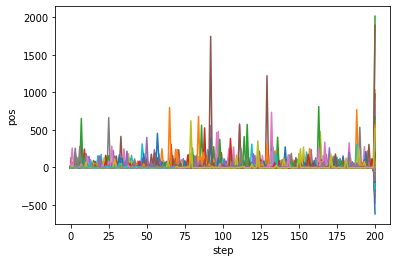

In [211]:
%matplotlib inline
import matplotlib.pyplot as plt

for obs in cb_train.rewards.values():
    plt.plot([o for o in obs])
plt.xlabel("step")
plt.ylabel("pos")

In [0]:
# dqn.load_weights("h5f/my_dqn_weights_try_modify_reward.h5f")


In [0]:
cb_ep = EpisodeLogger()

In [291]:
# 学習済モデルに対して、テストを実行 （必要に応じて適切なCallbackも定義、設定可能）
dqn.test(env, nb_episodes=200, visualize=False, callbacks=[cb_ep])

Testing for 200 episodes ...
Episode 1: reward: -896.600, steps: 201
Episode 2: reward: -90.600, steps: 201
Episode 3: reward: -260.400, steps: 201
Episode 4: reward: -275.400, steps: 201
Episode 5: reward: -343.400, steps: 201
Episode 6: reward: 60.600, steps: 201
Episode 7: reward: 433.000, steps: 201
Episode 8: reward: -311.000, steps: 201
Episode 9: reward: -94.000, steps: 201
Episode 10: reward: 1158.000, steps: 201
Episode 11: reward: 192.000, steps: 201
Episode 12: reward: -425.200, steps: 201
Episode 13: reward: 1283.200, steps: 201
Episode 14: reward: -323.000, steps: 201
Episode 15: reward: -212.000, steps: 201
Episode 16: reward: -209.400, steps: 201
Episode 17: reward: -792.200, steps: 201
Episode 18: reward: -266.400, steps: 201
Episode 19: reward: -291.000, steps: 201
Episode 20: reward: -236.000, steps: 201
Episode 21: reward: -562.200, steps: 201
Episode 22: reward: -436.800, steps: 201
Episode 23: reward: -523.200, steps: 201
Episode 24: reward: 412.400, steps: 201
Epi

Text(0, 0.5, 'pos')

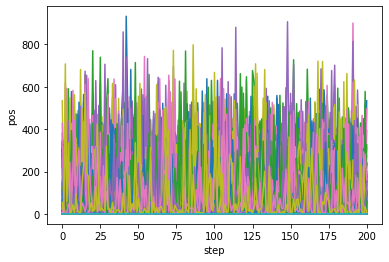

In [292]:
%matplotlib inline
import matplotlib.pyplot as plt

for obs in cb_ep.observations.values():
    plt.plot([o for o in obs])
plt.xlabel("step")
plt.ylabel("pos")

In [293]:
print(cb_ep.actions[0])

[6, 6, 6, 6, 5, 2, 2, 2, 6, 5, 2, 6, 0, 6, 6, 6, 2, 2, 0, 6, 6, 6, 6, 2, 6, 2, 6, 6, 6, 2, 5, 6, 0, 6, 6, 6, 2, 6, 6, 0, 6, 2, 0, 2, 2, 0, 6, 6, 2, 6, 6, 6, 6, 2, 2, 6, 5, 2, 6, 5, 6, 6, 0, 6, 6, 2, 2, 2, 2, 6, 0, 5, 2, 6, 6, 6, 6, 0, 2, 6, 6, 5, 2, 6, 2, 2, 5, 6, 6, 2, 6, 5, 2, 6, 5, 2, 6, 2, 6, 6, 6, 2, 5, 2, 6, 6, 6, 2, 6, 6, 2, 2, 6, 2, 5, 6, 6, 2, 2, 2, 6, 6, 2, 6, 6, 6, 6, 5, 6, 5, 6, 5, 0, 6, 2, 5, 2, 5, 6, 2, 2, 2, 6, 5, 5, 2, 6, 2, 2, 0, 5, 6, 6, 6, 2, 5, 6, 6, 5, 6, 2, 6, 6, 2, 2, 6, 6, 6, 6, 2, 5, 2, 2, 6, 5, 5, 0, 5, 2, 6, 6, 6, 6, 5, 2, 5, 6, 6, 0, 5, 5, 6, 6, 2, 2, 5, 6, 6, 5, 6, 2]


In [294]:
reward_amount = 0
for obs in cb_ep.rewards.values():
  print(np.array(obs).sum())
    # for o in obs:
      # print(o)
      # reward_amount += o


-896.5999999999999
-90.59999999999994
-260.3999999999999
-275.40000000000015
-343.4000000000001
60.6
433.00000000000006
-311.00000000000017
-94.00000000000003
1158.0000000000007
192.00000000000006
-425.20000000000005
1283.2000000000007
-323.0
-212.0
-209.40000000000003
-792.1999999999998
-266.4000000000001
-291.0000000000001
-236.0
-562.2
-436.80000000000007
-523.2
412.4
-277.00000000000006
241.6000000000001
-498.0000000000001
-491.20000000000005
-227.2
343.8000000000003
619.6
-131.80000000000004
-130.0
-821.1999999999996
1154.2
-283.80000000000007
921.2
-522.8
22.799999999999947
-271.80000000000007
-44.800000000000054
1098.2000000000007
-198.0000000000001
204.6
-617.6
-728.3999999999999
3365.2
1471.2000000000005
-423.20000000000005
-7.800000000000097
676.1999999999999
-298.0000000000001
96.3999999999999
56.800000000000054
-790.2
-18.599999999999937
-295.40000000000003
61.2
1266.8000000000004
-166.0
-356.4000000000001
-448.8000000000001
709.2000000000004
-111.40000000000015
-83.0000000

In [295]:
# テスト結果の報酬合計
amount = np.concatenate(list(cb_ep.rewards.values())).sum()
amount

1632.4000000000092

In [0]:
step_amount =  len(np.concatenate(list(cb_ep.rewards.values())))

In [297]:
step_amount

40200